In [1]:
#%matplotlib widget

from lib.hamiltonian import H_B, H_D, H_P
from lib.time import S
from lib import X, D
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from joblib import Memory
import itertools
import tqdm

memory = Memory(location=".joblib_cache", verbose=0)

N = 2
nsteps = 100
T_0 = 1
T_f = 900
pen = 5
beta = -1

Hf = H_B(N) + pen * H_P(N)
Hi = beta*H_D(N, X)

psi_f = np.diag(Hf)

P = np.array([1/2, 1/np.sqrt(2), 1/2], dtype="complex")
initialState = P.copy()
for _ in range(N-1):
    initialState = np.kron(initialState, P)

ts = np.linspace(T_0, T_f, nsteps)
f_all = False

After we have imported all of our dependencies, we can go ahead and implement the Time-dependent Schrodinger equation which was proposed by Yves Rezus.



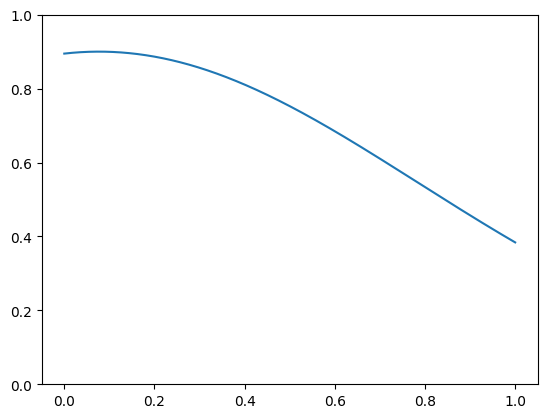

In [2]:
x = np.linspace(0, 1, 1000)
smax = 0.9
def St(x):
    # return smax*np.exp(-(x-D/2)**4/5000)
    return smax * np.exp(-(x - D/13)**2)

y = S(x)

plt.ylim([0, 1])
plt.plot(x, y)
plt.show()

To first understand how the energies change in this new scheme we should look at how the hamiltonian changes as we tune $ \gamma $ from 0 -> 1. 

$$
 H = \gamma*H_f + (1 - \gamma)*H_i
$$

In [3]:
def hamiltonian_energies(N):
    energies = []
    gamma_vals = []
    vecs = []
    
    for t in ts:
        gamma = t/T_f
        H = gamma * Hf + (1 - gamma) * Hi
        eigvals, vec = np.linalg.eigh(H)
        energies.append(eigvals)
        vecs.append(vec)
        gamma_vals.append(gamma)

    return np.array(energies), np.array(vecs), gamma_vals

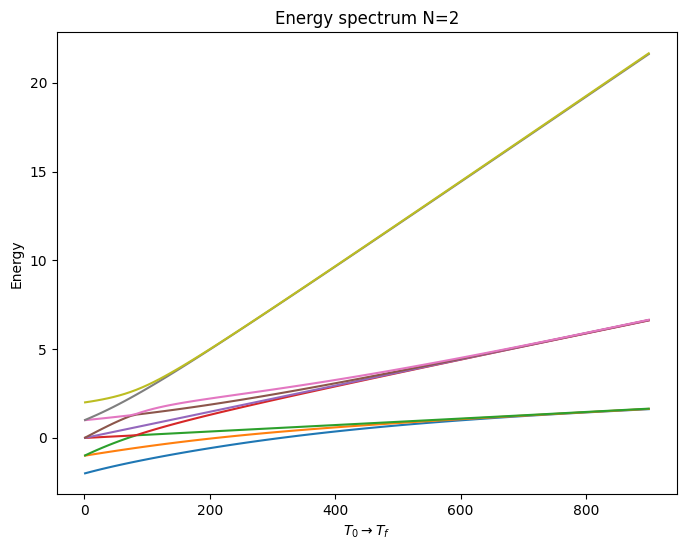

In [4]:
energies, vecs, gamma_vals = hamiltonian_energies(N)

plt.figure(figsize=(8, 6))
for i in range(energies.shape[1]):
    plt.plot(ts, energies[:, i])
plt.xlabel(r"$T_0 \to T_f$")
plt.ylabel("Energy")
plt.title(f"Energy spectrum {N=}")
plt.savefig("spectrum.pdf")
plt.show()

We can no see how the energy spectrum looks 

(-1, 1)


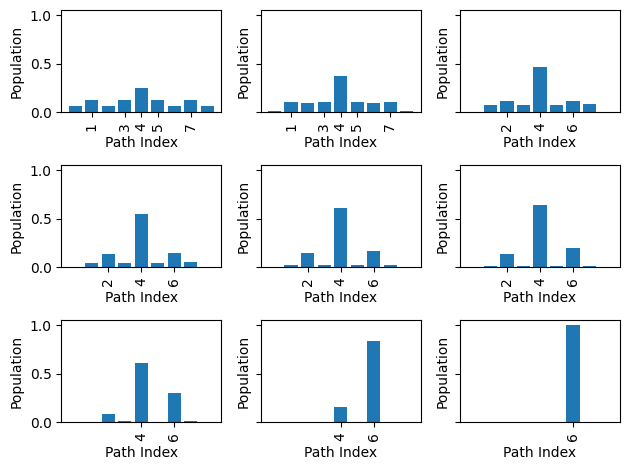

In [5]:
@memory.cache
def all_move_sequences(N):
    moves = (1, 0, -1)
    return list(itertools.product(moves, repeat=N))

vec = np.array([np.abs(v[:, 0])**2 for v in vecs])
fig, axes = plt.subplots(3, 3, sharey=True)
indices = np.arange(vecs.shape[1])
alpha_indices = np.linspace(0, len(vec)-1, 9, dtype=int)
selected_eigvecs = [vec[i] for i in alpha_indices]
moves = all_move_sequences(N)
for i, eigvec in enumerate(selected_eigvecs):
    ax = axes.flat[i]
    ax.bar(indices, eigvec, linewidth=1)
    ax_ids = []
    for j in range(len(eigvec)):
        if eigvec[j] > 1e-1:
            ax_ids.append(j)
    ax.set_xlabel("Path Index")
    ax.set_ylabel("Population")
    ax.set_xticks(ax_ids)
    ax.set_xticklabels(ax_ids, rotation=90)
last = selected_eigvecs[-1]
ind = np.argwhere(last > 1e-2)
for i in ind:
    print(moves[i[0]])

plt.tight_layout() 
plt.show()

In the plot above we can see which state we should end up in. 

This means that we only need to compute the following four matrix exponentials 
$$
\begin{eqnarray}
e^{A_0} & = & \exp\left[-i\gamma_0 H_f \frac{\Delta t^2}{4\hbar}\right]  \\
M_A & = & \exp\left[-i\gamma_0 H_f \frac{\Delta t^2}{2\hbar}\right]  \\
e^{B_0} & = & \exp \left[ -i H_i \frac{\Delta t}{\hbar} + 
i \gamma_0 H_i\frac{\Delta t^2}{2\hbar} \right]\\
M_B & = & \exp\left[i\gamma_0 H_i \frac{\Delta t^2}{\hbar}\right]
\end{eqnarray}
$$

In [12]:
@memory.cache
def yves_TDSE(psi_init, Hi, Hf, T, steps=10000, ret_all=False):
    dt = T / steps
    psi = psi_init.copy()

    eB = sp.linalg.expm(-1j * ( 1 - dt / (2*T)) * Hi * dt)
    MB = sp.linalg.expm(1j * Hi * dt**2/T)
    t = 0
    if ret_all:
        fids = []
        while t < T:
            eA = sp.linalg.expm(-1j*(t + dt / 2)*dt/(2*T)*Hf)
            #eB = sp.linalg.expm(-1j * (1 - (t+dt/2)/T) * Hi * dt)
            psi = eA @ eB @ eA @ psi
            # update eA and eB for next step using the recursion
            eB = MB @ eB
            t += dt
            fids.append(psi.copy())
        return fids
    
    while t < T:
        eA = sp.linalg.expm(-1j*(t + dt / 2)*dt/(2*T)*Hf)
        psi = eA @ eB @ eA @ psi
        # update eA and eB for next step using the recursion
        eB = MB @ eB
        t += dt

    return psi



6


  0%|                                                                                                  | 0/100 [00:00<?, ?it/s]

0.0001


  1%|▉                                                                                         | 1/100 [00:00<00:46,  2.12it/s]

0.0010080808080808082


  3%|██▋                                                                                       | 3/100 [00:01<00:33,  2.92it/s]

0.0019161616161616163
0.0028242424242424244


  5%|████▌                                                                                     | 5/100 [00:01<00:31,  3.05it/s]

0.0037323232323232323
0.004640404040404041


  7%|██████▎                                                                                   | 7/100 [00:02<00:29,  3.15it/s]

0.005548484848484849
0.006456565656565657


  9%|████████                                                                                  | 9/100 [00:02<00:29,  3.11it/s]

0.007364646464646465
0.008272727272727274


 11%|█████████▊                                                                               | 11/100 [00:03<00:28,  3.18it/s]

0.009180808080808081
0.01008888888888889


 13%|███████████▌                                                                             | 13/100 [00:04<00:27,  3.12it/s]

0.010996969696969696
0.011905050505050505


 15%|█████████████▎                                                                           | 15/100 [00:04<00:27,  3.11it/s]

0.012813131313131313
0.013721212121212122


 17%|███████████████▏                                                                         | 17/100 [00:05<00:26,  3.15it/s]

0.01462929292929293
0.015537373737373739


 19%|████████████████▉                                                                        | 19/100 [00:06<00:25,  3.16it/s]

0.016445454545454548
0.017353535353535354


 21%|██████████████████▋                                                                      | 21/100 [00:06<00:25,  3.13it/s]

0.018261616161616163
0.019169696969696972


 22%|███████████████████▌                                                                     | 22/100 [00:07<00:24,  3.15it/s]

0.02007777777777778


 24%|█████████████████████▎                                                                   | 24/100 [00:07<00:23,  3.21it/s]

0.020985858585858587
0.021893939393939393


 26%|███████████████████████▏                                                                 | 26/100 [00:08<00:23,  3.18it/s]

0.022802020202020202
0.02371010101010101


 28%|████████████████████████▉                                                                | 28/100 [00:08<00:21,  3.28it/s]

0.02461818181818182
0.025526262626262626


 30%|██████████████████████████▋                                                              | 30/100 [00:09<00:21,  3.27it/s]

0.026434343434343435
0.027342424242424244


 32%|████████████████████████████▍                                                            | 32/100 [00:10<00:21,  3.22it/s]

0.028250505050505054
0.02915858585858586


 34%|██████████████████████████████▎                                                          | 34/100 [00:10<00:20,  3.27it/s]

0.03006666666666667
0.030974747474747478


 36%|████████████████████████████████                                                         | 36/100 [00:11<00:19,  3.26it/s]

0.031882828282828284
0.03279090909090909


 37%|████████████████████████████████▉                                                        | 37/100 [00:11<00:19,  3.20it/s]

0.0336989898989899


 39%|██████████████████████████████████▋                                                      | 39/100 [00:12<00:18,  3.29it/s]

0.03460707070707071
0.03551515151515152


 41%|████████████████████████████████████▍                                                    | 41/100 [00:12<00:18,  3.17it/s]

0.03642323232323233
0.03733131313131313


 43%|██████████████████████████████████████▎                                                  | 43/100 [00:13<00:17,  3.19it/s]

0.03823939393939394
0.03914747474747475


 45%|████████████████████████████████████████                                                 | 45/100 [00:14<00:17,  3.14it/s]

0.04005555555555556
0.04096363636363637


 47%|█████████████████████████████████████████▊                                               | 47/100 [00:14<00:17,  3.01it/s]

0.04187171717171718
0.04277979797979799


 48%|██████████████████████████████████████████▋                                              | 48/100 [00:15<00:17,  3.05it/s]

0.04368787878787879


 49%|███████████████████████████████████████████▌                                             | 49/100 [00:15<00:17,  2.99it/s]

0.0445959595959596


 51%|█████████████████████████████████████████████▍                                           | 51/100 [00:16<00:16,  2.95it/s]

0.0455040404040404
0.04641212121212121


 53%|███████████████████████████████████████████████▏                                         | 53/100 [00:16<00:14,  3.17it/s]

0.04732020202020202
0.04822828282828283


 54%|████████████████████████████████████████████████                                         | 54/100 [00:17<00:14,  3.25it/s]

0.04913636363636364


 56%|█████████████████████████████████████████████████▊                                       | 56/100 [00:17<00:13,  3.16it/s]

0.05004444444444445
0.050952525252525256


 58%|███████████████████████████████████████████████████▌                                     | 58/100 [00:18<00:13,  3.20it/s]

0.051860606060606065
0.05276868686868687


 60%|█████████████████████████████████████████████████████▍                                   | 60/100 [00:19<00:12,  3.14it/s]

0.05367676767676768
0.054584848484848486


 61%|██████████████████████████████████████████████████████▎                                  | 61/100 [00:19<00:12,  3.15it/s]

0.055492929292929295


 63%|████████████████████████████████████████████████████████                                 | 63/100 [00:20<00:11,  3.12it/s]

0.056401010101010104
0.057309090909090914


 65%|█████████████████████████████████████████████████████████▊                               | 65/100 [00:20<00:11,  3.12it/s]

0.05821717171717172
0.05912525252525253


 67%|███████████████████████████████████████████████████████████▋                             | 67/100 [00:21<00:10,  3.29it/s]

0.060033333333333334
0.060941414141414144


 69%|█████████████████████████████████████████████████████████████▍                           | 69/100 [00:21<00:09,  3.30it/s]

0.06184949494949495
0.06275757575757576


 71%|███████████████████████████████████████████████████████████████▏                         | 71/100 [00:22<00:09,  3.20it/s]

0.06366565656565656
0.06457373737373738


 73%|████████████████████████████████████████████████████████████████▉                        | 73/100 [00:23<00:08,  3.20it/s]

0.06548181818181818
0.066389898989899


 75%|██████████████████████████████████████████████████████████████████▊                      | 75/100 [00:23<00:07,  3.21it/s]

0.0672979797979798
0.06820606060606062


 77%|████████████████████████████████████████████████████████████████████▌                    | 77/100 [00:24<00:07,  3.26it/s]

0.06911414141414142
0.07002222222222222


 79%|██████████████████████████████████████████████████████████████████████▎                  | 79/100 [00:24<00:06,  3.30it/s]

0.07093030303030304
0.07183838383838384


 81%|████████████████████████████████████████████████████████████████████████                 | 81/100 [00:25<00:05,  3.29it/s]

0.07274646464646466
0.07365454545454546


 83%|█████████████████████████████████████████████████████████████████████████▊               | 83/100 [00:26<00:05,  3.18it/s]

0.07456262626262627
0.07547070707070708


 85%|███████████████████████████████████████████████████████████████████████████▋             | 85/100 [00:26<00:04,  3.20it/s]

0.0763787878787879
0.0772868686868687


 86%|████████████████████████████████████████████████████████████████████████████▌            | 86/100 [00:27<00:04,  3.14it/s]

0.0781949494949495


 88%|██████████████████████████████████████████████████████████████████████████████▎          | 88/100 [00:27<00:03,  3.19it/s]

0.07910303030303031
0.08001111111111112


 89%|███████████████████████████████████████████████████████████████████████████████▏         | 89/100 [00:28<00:03,  3.16it/s]

0.08091919191919193


 91%|████████████████████████████████████████████████████████████████████████████████▉        | 91/100 [00:28<00:02,  3.18it/s]

0.08182727272727273
0.08273535353535355


 93%|██████████████████████████████████████████████████████████████████████████████████▊      | 93/100 [00:29<00:02,  3.13it/s]

0.08364343434343435
0.08455151515151516


 95%|████████████████████████████████████████████████████████████████████████████████████▌    | 95/100 [00:30<00:01,  3.08it/s]

0.08545959595959597
0.08636767676767677


 97%|██████████████████████████████████████████████████████████████████████████████████████▎  | 97/100 [00:30<00:00,  3.16it/s]

0.08727575757575758
0.08818383838383838


 99%|████████████████████████████████████████████████████████████████████████████████████████ | 99/100 [00:31<00:00,  3.19it/s]

0.0890919191919192
0.09


100%|████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.17it/s]


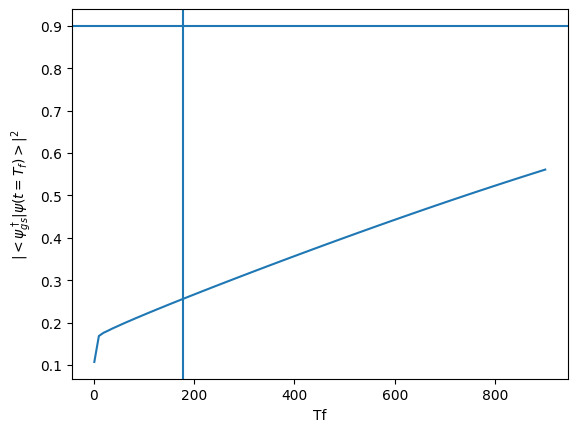

In [7]:
fidelities = []
gs_idx = np.argmin(psi_f)
print(gs_idx)

for t in tqdm.tqdm(ts):
    psi = yves_TDSE(initialState, Hi, Hf, t)
    fidelity = np.abs(psi[gs_idx])**2
    fidelities.append(fidelity)


plt.figure()
#plt.ylim(0, 1)
plt.xlabel("Tf")
plt.ylabel(r"$ |<\psi^\dagger_{gs} | \psi(t=T_f)>|^2 $")
plt.plot(ts, fidelities)
plt.axhline(0.9)
plt.axvline(178)
plt.savefig(f"{N=}-different_Tf.pdf")
plt.show()

In [8]:
import csv
fidelities = np.array(fidelities)
with open("fids3.csv", "a") as f:
    writer = csv.writer(f)
    
    writer.writerow([N, fidelities.tolist()])

In [9]:
"""
Lets implement a variant of binary search for TDSE fidelity

Requirements:
    Fid: Some value we want to achieve
    epsilon: Some threshold to be within
    S: The start value for our search
    E: The estimated end value to reach atlease 98% fidelity, this is a soft cap

We assume the following:

F(S) <= Fid + epsilon AND F(E) >= Fid - epsilon

If F(E) < Fid - epsilon: We have to expand our search space.
"""

gs_idx = np.argmin(psi_f)
print(gs_idx)

def calc_fid(initialState, Hi, Hf, t):
    psi = yves_TDSE(initialState, Hi, Hf, t)
    return np.abs(psi[gs_idx])**2

S = T_0
E = T_f


print(S, E)

Fid = 0.9
epsilon = 0.001

start = calc_fid(initialState, Hi.copy(), Hf.copy(), S)
print(start)
end = calc_fid(initialState, Hi.copy(), Hf.copy(), E)
print(end)

if start <= Fid + epsilon and end >= Fid - epsilon:
    print(f"{Fid=} is within our search space")
else:
    print(f"Fid is outside of search space")
    max_expand = 10
    expand = 0
    while end <= Fid - epsilon and expand < max_expand:
        E *= 1.5
        end = calc_fid(initialState, Hi.copy(), Hf.copy(), E)
        expand += 1

    print(f"Found a better end value for end with {E=}")

while (E - S) > epsilon:
    print(f"({S} + {E}) / 2")
    mid = (S + E) / 2
    fmid = calc_fid(initialState, Hi.copy(), Hf.copy(), mid)
    print(f"Checking value at {mid=} {fmid=}")
    if Fid - epsilon <= fmid <= Fid + epsilon:
        print(f"Found a solution that satisfies our Fid ~ 0.9 with {fmid=} and Tf={mid}")
        break
    if fmid < Fid - epsilon:
        S = mid 
    else:
        E = mid

6
1 900
0.0001
0.107111448493978
0.09
0.5566802328851013
Fid is outside of search space
0.135
0.2025
0.30375
Found a better end value for end with E=3037.5
(1 + 3037.5) / 2
0.151925
Checking value at mid=1519.25 fmid=np.float64(0.800407171885849)
(1519.25 + 3037.5) / 2
0.2278375
Checking value at mid=2278.375 fmid=np.float64(0.9596020349729026)
(1519.25 + 2278.375) / 2
0.18988125
Checking value at mid=1898.8125 fmid=np.float64(0.859503484187263)
(1898.8125 + 2278.375) / 2
0.208859375
Checking value at mid=2088.59375 fmid=np.float64(0.8999680423711243)
Found a solution that satisfies our Fid ~ 0.9 with fmid=np.float64(0.8999680423711243) and Tf=2088.59375


0.20000511398


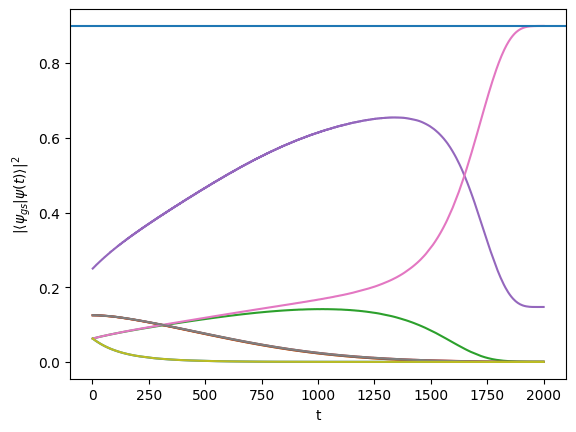

In [10]:
Tf = 2000.0511398

fids = yves_TDSE(initialState, Hi, Hf, Tf, ret_all=True)
Ts = np.linspace(T_0, Tf, len(fids))

# fids /= np.linalg.norm(fids)

fidelities = np.abs(fids)**2

plt.plot(Ts, fidelities)
plt.xlabel("t")
plt.axhline(0.9)
plt.ylabel(r"$|\langle \psi_{gs} | \psi(t) \rangle|^2$")
plt.show()


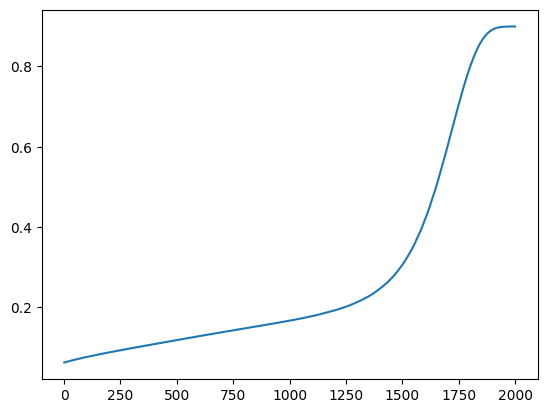

In [11]:
f = []
for i in fids:
    f.append(np.abs(i[gs_idx])**2)

plt.plot(Ts, f)
plt.show()